# Curso de Machine Learning
# Clustering: k-means, DBSCAN
## Luis Duarte, Sebastian Filipigh, Magdalena Lucini
### Septiembre 2023, FaCENA - UNNE
### Contacto:  luis.duarte@comunidad.unne.edu.ar; sfilipigh@comunidad.unne.edu.ar; mmlucini@comunidad.unne.edu.ar



**Objetivos:**

*   Aplicar técnicas de clustering a bases de datos reales.
*   Comparar agrupaciones con diferentes ténicas.

**Antes de empezar:**

Necesitamos importar las siguientes librerías:

In [ ]:
import numpy as np
%matplotlib inline
%pylab inline
import pandas as pd
import io
import torch
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN
from sklearn import decomposition


Populating the interactive namespace from numpy and matplotlib


In [ ]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

## Importación de datos:
------------------------------------------
Importemos la base de datos 'paises.csv'.


In [ ]:
uploaded = files.upload()

In [ ]:
paises = pd.read_csv(io.BytesIO(uploaded['paises.csv']), index_col=0)

*   Observe qué variables tiene la base de datos.
*   Obtenga las medidas de resumen para las variables.


In [ ]:
paises

In [ ]:
paises.describe()

La base de datos "paises.csv" corresponde a una muestra de 26 países con las siguientes varriables:

* **BirthRate:** Tasa de natalidad.
* **DeathRate:** Tasa de mortalidad.
* **PopulationGainLoss:** Ganancia o pérdida de población.
* **InfantMortalityRate:** Tasa de mortalidad infantil.
* **Age65:** Edad 65.
* **LifeExpectancyBirth:** Expectativa de vida al nacer.
* **LifeExpectancyBirthMales:** Expectativa de vida al nacer (hombres).
* **LifeExpectancyBirthFemales:** Expectativa de vida al nacer (mujeres).
* **UrbanPopulation:** Población urbana.

Veamos cómo se distribuyen los datos:

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(paises.BirthRate, paises.DeathRate,'b*')
axs[0, 0].set_xlabel('Tasa de natalidad')
axs[0, 0].set_ylabel('Tasa de mortalidad')
axs[0, 0].set_title('Diagrama de Dispersión')

axs[0, 1].plot(paises.LifeExpectancyBirth, paises.UrbanPopulation, 'b*')
axs[0, 1].set_xlabel('Expectativa de Vida')
axs[0, 1].set_ylabel('Población urbana')
axs[0, 1].set_title('Diagrama de Dispersión')


axs[1, 0].plot(paises.BirthRate, paises.UrbanPopulation, 'b*')
axs[1, 0].set_xlabel('Tasa de natalidad')
axs[1, 0].set_ylabel('Población urbana')
axs[1, 0].set_title('Diagrama de dispersión')

axs[1, 1].plot(paises.BirthRate, paises.LifeExpectancyBirth, 'b*')
axs[1, 1].set_xlabel('Tasa de natalidad')
axs[1, 1].set_ylabel('Esperanza de Vida')
axs[1, 1].set_title('Diagrama de dispersión')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

* Como vimos, las variables en la base poseen escalas muy distintas por lo que es necesario escalarlas.

In [ ]:
scaler = StandardScaler()
paises_esc = scaler.fit_transform(paises)

## Clustering: K-means

Una vez escalados los datos, procemos a generar los clusters. Tenemos que decidir:
1. **¿Elegimos los centroides o los definimos de manera aleatoria?**

Una opción es (la que seguiremos en este curso) generar los centroides de manera aleatoria utilizando la función *KMeans* de la librería *sklearn*.


2.   **¿Cuántos clusters formamos?**


*   **Regla de Hartigan**: Considera la diferencia entre la SCD (Suma de Cuadrados Dentro) con $g$ y $g +1$ grupos, analizando la reducción de variabilidad relativa tras un agrupamiento adicional:
$$F=\cfrac{\mathbf{W}_g-\mathbf{W}_{g+1}}{\cfrac{\mathbf{W}_{g+1}}{n-g-1}}$$
donde $\mathbf{W}_g$ es la suma de cuadrados dentro, para $g$ grupos.\
Hartigan (1975) sugiere introducir un grupo más si $F>10$.

*   **Coeficiente de Silhouette (SC)**: Es una métrica de validación interna empleada para la elección de medida de distancia, algoritmo de aglomeración o número de clusters a considerar. Nos proporciona una medida de cuán similar es un objeto a su propio grupo (cohesión) en comparación con otros grupos (separación).\
Rousseew(1987) propuso la siguiente interpretación del coeficiente SC:
     *   0.71-1: estructura fuerte.
     *   0.51-0.7: se encontró una estructura razonable.
     *   0.26-0.5: estructura débil y podría ser artificial.
     *   menor a 0.25: sin estructura sustancial.

Teniendo en cuenta lo anterior, crearemos diferentes estructuras utilizando 2, 3, 4, 5 y 6 clusters y, utilizando la reglas propuestas
, decidiremos con cuántos clusters trabajaremos.

In [ ]:
# Definir el rango de números de clusters
num_clusters = range(2,7)

# Lista para almacenar la inercia (SCD)
SCD = []

# Calcular la inercia para cada número de clusters
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(paises_esc)
    inertia = kmeans.inertia_
    SCD.append(inertia)

# Mostrar la inercia para cada número de clusters
for k, inertia in zip(num_clusters, SCD):
    print(f'Número de Clusters: {k}, Inercia: {inertia}')

In [ ]:
# Dibujar un gráfico de codo para visualizar la inercia
plt.figure(figsize=(8, 6))
plt.plot(num_clusters, SCD, marker='o', linestyle='-')
plt.title('Gráfico de Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Cuadrados Dentro')
plt.show()

In [ ]:
#Calculamos los valores de F
for k in range(len(SCD)-1):
  F=(SCD[k]-SCD[k+1])/(SCD[k+1]/(len(paises_esc)-k-3))
  print(F)

Luego, de acuerdo a la regla de Hartigan, nos quedamos con 4 clusters.

**Tarea:** Analice el siguiente código y obtenga conclusiones.


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(paises_esc) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(paises_esc)
    silhouette_avg = silhouette_score(paises_esc, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "el CS es:", silhouette_avg)

    sample_silhouette_values = silhouette_samples(paises_esc, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Gráfico de CS para varios nros. de clusters")
    ax1.set_xlabel("CS")
    ax1.set_ylabel("Nombre del Cluster")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Análisis de silueta para Clustering por K-Means con n_clusters= %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

*  Veamos cómo quedan conformados los 4 grupos.

In [ ]:
n_clust = 4
km = KMeans(n_clusters= n_clust)
km.fit(paises_esc)
clusters = km.labels_ #indica a qué cluster es asignado cada país.

In [ ]:
df_clusters=paises.copy() #Hago una copia de la base original
df_clusters['kmeans_4'] = km.labels_ #Agrego los clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clusters

* Proyectemos los datos en las dos primeras componentes principales y veamos su estructura.

In [ ]:
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(paises_esc)
df_clusters['PC1']=reduced_data[:,0]
df_clusters['PC2']=reduced_data[:,1]
kmean_clusters = go.Scatter(x=df_clusters['PC1'], y=df_clusters['PC2'],
                           mode='markers',
                           text=df_clusters.index.tolist(),
                           marker=dict(
                                size=5,
                                color = df_clusters['kmeans_4'].astype(np.float), #set color equal to a variable
                                colorscale='Rainbow',
                                showscale=False)
                           )
layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title='PC1'),
                yaxis=dict(title='PC2'),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=kmean_clusters, layout=layout)

In [ ]:
fig.show(renderer="colab")

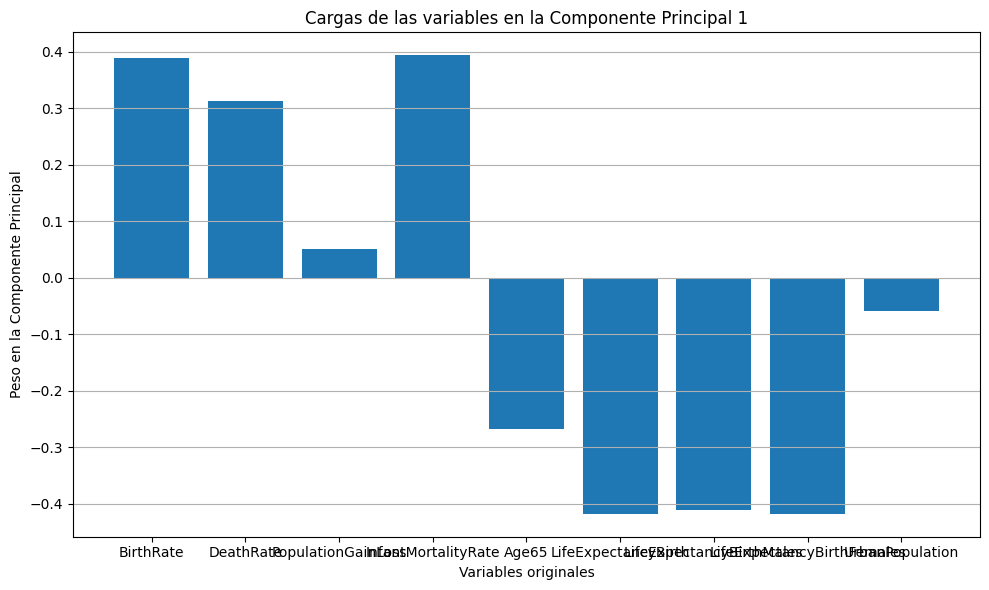

In [ ]:
component_number = 0
plt.figure(figsize=(10, 6))
rd=pca.components_
plt.bar(range(rd.shape[1]), rd[component_number, :])
plt.xlabel('Variables originales')
plt.ylabel('Peso en la Componente Principal')
plt.title(f'Cargas de las variables en la Componente Principal {component_number + 1}')
plt.xticks(range(rd.shape[1]), paises.columns.tolist())
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
kmean_clusters = go.Scatter(x=df_clusters['BirthRate'], y=df_clusters['LifeExpectancyBirth'],
                           mode='markers',
                           text=df_clusters.index.tolist(),
                           marker=dict(
                                size=5,
                                color = df_clusters['kmeans_4'].astype(np.float), #set color equal to a variable
                                colorscale='Rainbow',
                                showscale=False)
                           )
layout = go.Layout(title="Variables Originales",titlefont=dict(size=20),
                xaxis=dict(title='Tasa de natalidad'),
                yaxis=dict(title='Esperanza de Vida'),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=kmean_clusters, layout=layout)

NameError: ignored

## Clustering: DBSCAN

**Density Based Spatial Clusterig of Applications with Noise
(DBSCAN)**\
▶ **Clusters:** regiones densas en el espacio de datos, separadas
por regiones de baja densidad de puntos.\
▶ **Idea básica:** Para que un punto pertenzca a un cluster , un
entorno de un radio dado, centrado en ese punto, tiene que
contener una cantidad m ́ınima de puntos.\
▶ Puede encontrar clusters de diferentes formas y tamaños ,
detecta ruido y puntos outliers.

**Parámetros**:\
▶ $\mathbf{\epsilon}$ (eps) = define el entorno (vecindad) de un punto: Si
$d\left(x_i, x_j\right)< \epsilon ⇒ x_i \text{ y } x_j$ son “vecinos”.\
▶ **min Pts**: número mínimo de vecinos (puntos) dentro de un
radio $\epsilon$ (define así zonas “densas”).

**Criterios de Elección de Parámetros:**
* **min Pts**\
▶ $min Pts \leq p + 1$, con $p=$ cantidad de variables.\
▶ Si el data set es muy ruidoso, $min Pts$ debe ser al menos $2p$.

* $\mathbf{\epsilon}$\
▶$\epsilon$ pequeño → muchos datos sin agrupar; $\epsilon$ muy grande → la
mayoría de los datos en un mismo grupo.\
▶ puede elegirse usando un gráfico de distancias (gráfico de
codo, knee graph), representando la distancia al $k= min Pts-1$ vecino más cercano, ordenadas de mayor a menor. Se elige $\epsilon$ donde se observa un codo.\
▶ para cada punto se detecta su vecino más cercano, se fija $\epsilon$
de manera tal que una proporción suficientemente gande de
observaciones (> 90%) tenga una distancia a su vecino más
cercano inferio a $\epsilon$.


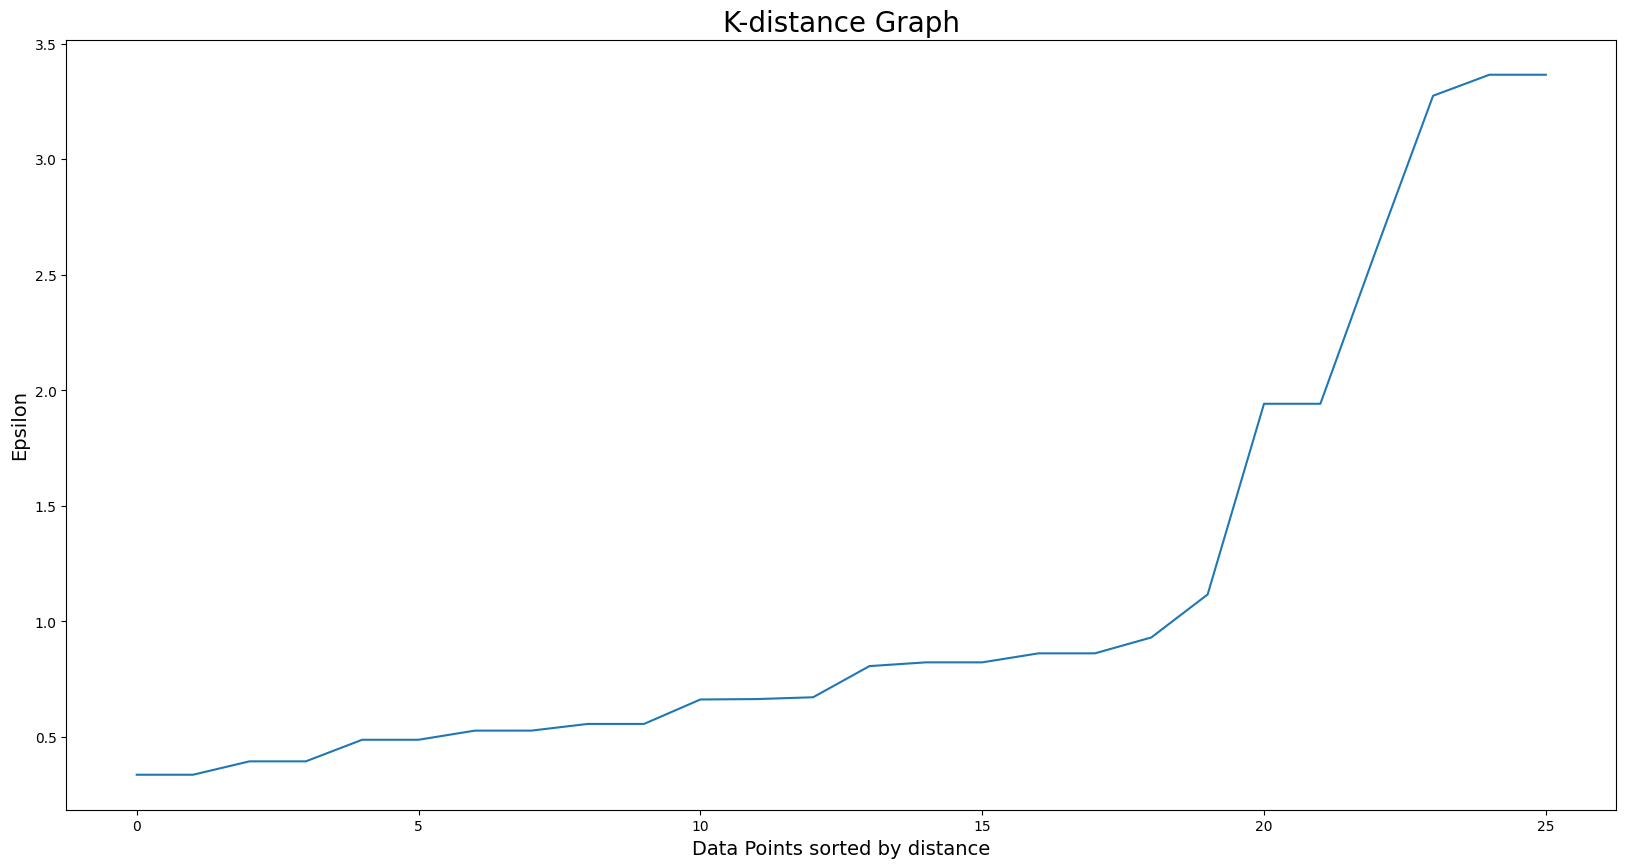

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=8)
nbrs = neigh.fit(paises_esc)
distances, indices = nbrs.kneighbors(paises_esc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

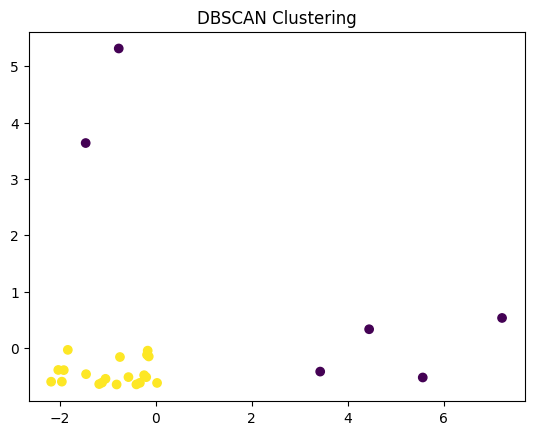

In [ ]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=17)
clusters = dbscan.fit_predict(paises_esc)

# Visualizar el resultado
plt.scatter(df_clusters['PC1'], df_clusters['PC2'], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()